In [13]:
import sys; sys.path.append("..") # to fix imports

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import time

from utils.data_utils import load_and_process_data
from utils.model_utils import regression_report, fit_and_plot_regression_model

# Load Data and Process into feature matrix and target vector

In [14]:
# load and process data
data = load_and_process_data(train_path= '../data/train.csv', test_path = '../data/test.csv')

data.head()

id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,train,bmi,Sex_encoded
i64,i64,f64,f64,f64,f64,f64,f64,bool,f64,i64
0,36,189.0,82.0,26.0,101.0,41.0,150.0,true,22.955684,0
1,64,163.0,60.0,8.0,85.0,39.7,34.0,true,22.582709,1
2,51,161.0,64.0,7.0,84.0,39.8,29.0,true,24.690405,1
3,20,192.0,90.0,25.0,105.0,40.7,140.0,true,24.414062,0
4,38,166.0,61.0,25.0,102.0,40.6,146.0,true,22.13674,1


In [15]:
feature_names = ['Sex_encoded', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'bmi']
target_name = 'Calories'

In [16]:
# separate train and test data as well as features and target. Check shapes
train_data = data.filter(pl.col('train') == True)
test_data = data.filter(pl.col('train') == False)

X_train = train_data.select(feature_names)
y_train = train_data.select(target_name).to_numpy().flatten() # it's convenient for now to have the features be a polars df but the target is a numpy array

X_test = test_data.select(feature_names)
# no target for the test data 

X_train.shape, y_train.shape, X_test.shape

((750000, 8), (750000,), (250000, 8))

# Initial Random Forest and XGBoost Models (default parameters) + Cross Validation

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict

from xgboost import XGBRegressor

In [18]:
model_name_to_model = {'XGBRegressor (default)': XGBRegressor(random_state=1738)}
        #   'RandomForestRegressor (default)': RandomForestRegressor(random_state=1738)}   

--------------------------------------------------
Cross-validating and making predictions with XGBRegressor (default)...


Time taken: 3.42 seconds
R2: 0.9963
MSE: 14.40368
MAE: 2.35894
RMSE: 3.79522
RMSLE: 0.06588


<Figure size 800x600 with 0 Axes>

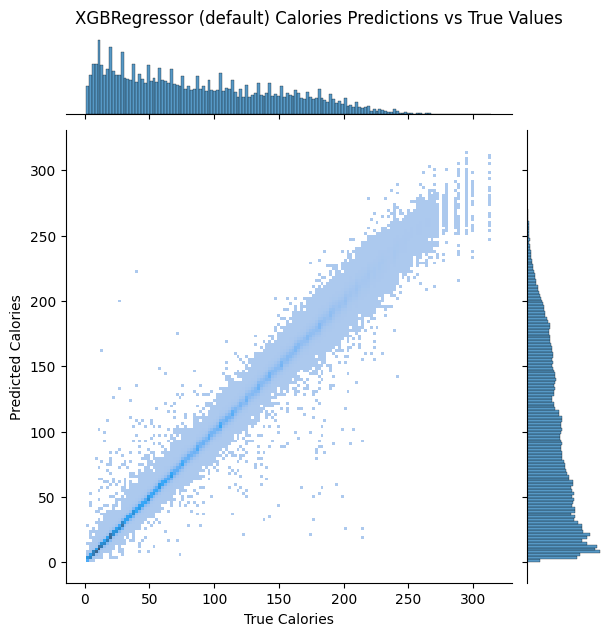

In [19]:
regression_reports = {}

for model_name, model in model_name_to_model.items():
    fit_and_plot_regression_model(model, model_name, X_train, y_train, target_name)

**Takeaways**: Both models perform well with default parameters and the full training set, although xgboost is much faster. I'll focus on xgb for the ablation study and hyperparameter tuning

# Recursive Feature Elimination with default XGBRegressor

Now, I want to try and determine feature importance and see if reducing the number of features improves or makes no difference to performance. If so, I'll exclude unimportant features for the sake of reducing complexity 

In [20]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV

In [21]:
cv = 10

splitter = KFold(n_splits=cv, shuffle=True, random_state=1738)

feature_importances = np.zeros(shape=(cv, X_train.shape[1]))

for i, (train_idx, test_idx) in enumerate(splitter.split(X_train)):
    X_train_split, X_test_split = X_train[train_idx], X_train[test_idx]
    y_train_split, y_test_split = y_train[train_idx], y_train[test_idx]

    # fit the model
    model = XGBRegressor(random_state=1738)
    model.fit(X_train_split, y_train_split)

    feature_importances[i] = model.feature_importances_

    if i == 0:
        feature_names = model.feature_names_in_

Text(0.5, 1.0, 'Feature Importance Predicting Calorie Expenditure for XGBRegressor')

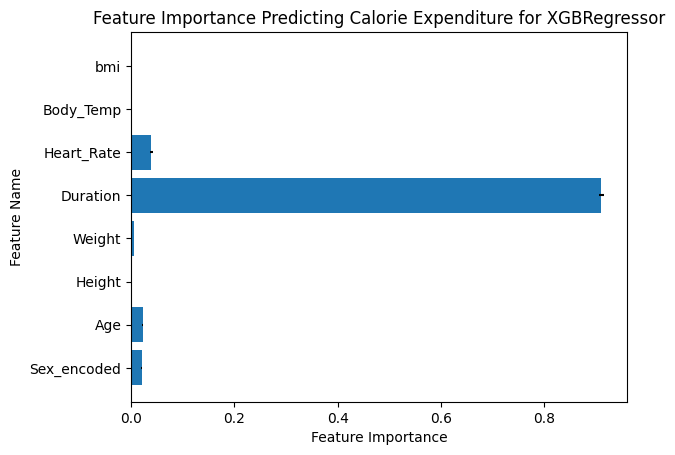

In [22]:
# collect and display the feature importances
feature_importance_means = feature_importances.mean(axis=0)
feature_importance_stds = feature_importances.std(axis=0)

feature_name_to_importance_mean = {feature_name: feature_importance_mean for feature_name, feature_importance_mean in zip(feature_names, feature_importance_means)}
feature_name_to_importance_std = {feature_name: feature_importance_std for feature_name, feature_importance_std in zip(feature_names, feature_importance_stds)}

plt.barh(list(feature_name_to_importance_mean.keys()), list(feature_name_to_importance_mean.values()), xerr=list(feature_name_to_importance_std.values()))
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Predicting Calorie Expenditure for XGBRegressor')

In [23]:
# perform recursive feature elimination with cross-validation
selector = RFECV(estimator=XGBRegressor(random_state=1738), step=1, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

selector = selector.fit(X_train, y_train)

In [24]:
# which features were selected to keep vs remove?
keep_feature_mask = selector.support_

features_to_keep = selector.feature_names_in_[keep_feature_mask]
features_to_remove = selector.feature_names_in_[~keep_feature_mask]

print(f"Features to keep: {features_to_keep}")
print(f"Features to remove: {features_to_remove}")

Features to keep: ['Sex_encoded' 'Age' 'Weight' 'Duration' 'Heart_Rate' 'Body_Temp']
Features to remove: ['Height' 'bmi']


In [25]:
# actually select the features
X_train_selected, X_test_selected = X_train[:, keep_feature_mask], X_test[:, keep_feature_mask]

assert X_train_selected.columns == features_to_keep.tolist(), "Selected features do not match expected features"

X_train_selected.shape, X_test_selected.shape

((750000, 6), (250000, 6))

In [26]:
# fit the model with the selected features as a quick test
model = XGBRegressor(random_state=1738)

y_train_pred = cross_val_predict(model, X_train_selected, y_train, cv=10, n_jobs=-1)

report = regression_report(y_train, y_train_pred)
regression_reports[model_name] = report

for metric_name, metric_value in report.items():
    print(f"{metric_name}: {round(metric_value, 5)}")

R2: 0.99633
MSE: 14.29875
MAE: 2.34624
RMSE: 3.78137
RMSLE: 0.06522


# Hyperparameter Tuning XGBRegressor With Optuna

In [30]:
import optuna
from utils.model_utils import objective_xgb_regressor_rmsle

In [32]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective_xgb_regressor_rmsle(trial, X_train_selected.to_numpy(), y_train), n_trials=50)

[I 2025-05-16 19:39:12,082] A new study created in memory with name: no-name-2da110bc-1405-42cf-a326-ab4143b03f25
[I 2025-05-16 19:39:16,295] Trial 0 finished with value: 0.0776367423501011 and parameters: {'max_depth': 4, 'min_child_weight': 3.5347913162596383}. Best is trial 0 with value: 0.0776367423501011.
[I 2025-05-16 19:39:21,322] Trial 1 finished with value: 0.06568665427248 and parameters: {'max_depth': 6, 'min_child_weight': 9.059013397676761}. Best is trial 1 with value: 0.06568665427248.
[I 2025-05-16 19:39:27,837] Trial 2 finished with value: 0.0627255860595245 and parameters: {'max_depth': 10, 'min_child_weight': 9.89445999152063}. Best is trial 2 with value: 0.0627255860595245.
[I 2025-05-16 19:39:33,906] Trial 3 finished with value: 0.0625193460256137 and parameters: {'max_depth': 8, 'min_child_weight': 1.7724894391030568}. Best is trial 3 with value: 0.0625193460256137.
[I 2025-05-16 19:39:39,642] Trial 4 finished with value: 0.06305059628490774 and parameters: {'max_d

--------------------------------------------------
Cross-validating and making predictions with XGBRegressor (best parameters via optuna)...
Time taken: 3.88 seconds
R2: 0.99642
MSE: 13.9465
MAE: 2.22838
RMSE: 3.7345
RMSLE: 0.06234


<Figure size 800x600 with 0 Axes>

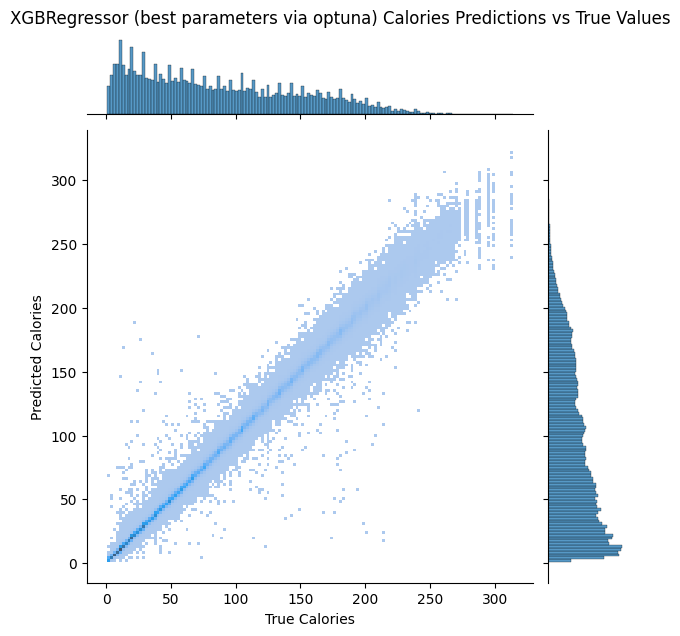

{'R2': 0.9964177038537642,
 'MSE': 13.946503611714899,
 'MAE': 2.2283816626290482,
 'RMSE': 3.734501788955911,
 'RMSLE': 0.06234105629161742}

In [33]:
best_params_model = XGBRegressor(**study.best_params, random_state=1738)

fit_and_plot_regression_model(best_params_model, "XGBRegressor (best parameters via optuna)", X_train_selected, y_train, target_name)

# Model Performance Analysis - Who does it work best/worst for?

# Summary